In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from score import evalscores

In [3]:
import json

In [4]:
all_reports_df = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_tags_df.pkl')

In [5]:
all_reports_df.head(2)

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
0,CXR2357_IM-0921-1001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...
1,CXR2357_IM-0921-2001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...


In [6]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
        
        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas

In [7]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True, visualize=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    
    if visualize:
        for t in range(len(words)):
            if t > 50:
                break
            plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

            plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
            plt.imshow(image)
            current_alpha = alphas[t, :]
            if smooth:
                alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
            else:
                alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
            if t == 0:
                plt.imshow(alpha, alpha=0)
            else:
                plt.imshow(alpha, alpha=0.8)
            plt.set_cmap(cm.Greys_r)
            plt.axis('off')
        plt.show()
    
    return words

In [8]:
parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')

parser.add_argument('--img', '-i', default='/home/dchesakov/NLMCXR_data/myface.jpg', help='path to image')
parser.add_argument('--model', '-m', default='BEST_checkpoint_NLMCXR_v10_1_cap_per_img_6_min_word_freq.pth.tar', help='path to model')
parser.add_argument('--word_map', '-wm', default='/home/dchesakov/NLMCXR_data/WORDMAP_NLMCXR_v10_1_cap_per_img_6_min_word_freq.json',  help='path to word map JSON')
parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')

_StoreFalseAction(option_strings=['--dont_smooth'], dest='smooth', nargs=0, const=False, default=True, type=None, choices=None, help='do not smooth alpha overlay', metavar=None)

In [9]:
'CXR3275_IM-1556-1003002'

'CXR3275_IM-1556-1003002'

In [10]:
# Load model
args = parser.parse_args('')

In [11]:
checkpoint = torch.load(args.model)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(args.word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
# seq, alphas = caption_image_beam_search(encoder, decoder, args.img, word_map, args.beam_size)
# alphas = torch.FloatTensor(alphas)

# # Visualize caption and attention of best sequence
# visualize_att(args.img, seq, alphas, rev_word_map, args.smooth)

In [12]:
word_map

{'advanced': 1,
 'dr': 2,
 'overload': 3,
 'improved': 4,
 'overlapping': 5,
 'incompletely': 6,
 'of': 7,
 'radiograph': 8,
 'monitor': 9,
 'typical': 10,
 'cavity': 11,
 'p': 12,
 'exposure': 13,
 'image': 14,
 'old': 15,
 'cabg': 16,
 'radiographs': 17,
 'large': 18,
 'suture': 19,
 'hours': 20,
 'wedge': 21,
 'discrete': 22,
 'probably': 23,
 'possibility': 24,
 'hernia': 25,
 'foreign': 26,
 'views': 27,
 'lymphadenopathy': 28,
 'atrial': 29,
 'line': 30,
 'or': 31,
 'basilar': 32,
 'x': 33,
 'entirely': 34,
 'irregular': 35,
 'other': 36,
 'below': 37,
 'senescent': 38,
 'splenic': 39,
 'increase': 40,
 'excavatum': 41,
 'crowded': 42,
 'questionable': 43,
 '2': 44,
 '1': 45,
 'positioning': 46,
 'thoracotomy': 47,
 'pectus': 48,
 'pathologic': 49,
 'dissection': 50,
 'limits': 51,
 'pneumonia': 52,
 'overlie': 53,
 'pulmonary': 54,
 'corresponding': 55,
 'severe': 56,
 'quality': 57,
 'caliber': 58,
 'placement': 59,
 '5th': 60,
 'normally': 61,
 'abnormal': 62,
 'another': 63,


In [8]:
def get_print(img_name, visualize=True, print_res=True):
    parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')
    parser.add_argument('--img', '-i', default=f'/home/dchesakov/NLMCXR_data/images/{img_name}.png', help='path to image')
    parser.add_argument('--model', '-m', default='BEST_checkpoint_NLMCXR_v10_1_cap_per_img_6_min_word_freq.pth.tar', help='path to model')
    parser.add_argument('--word_map', '-wm', default='/home/dchesakov/NLMCXR_data/WORDMAP_NLMCXR_v10_1_cap_per_img_6_min_word_freq.json',  help='path to word map JSON')
    parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
    parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')
    
    args = args = parser.parse_args('')
    
    checkpoint = torch.load(args.model)
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(args.word_map, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search(encoder, decoder, args.img, word_map, args.beam_size)
    alphas = torch.FloatTensor(alphas)
    
    if print_res:
        print(asd[ asd['images'] == f'{img_name}']['processed_findings'].iloc[0])

    # Visualize caption and attention of best sequence
    words = visualize_att(args.img, seq, alphas, rev_word_map, args.smooth, visualize=visualize)
    
    return words

In [14]:
import pandas as pd

In [15]:
asd = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_df.pkl')

In [16]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

all_reports_df = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_tags_df.pkl')
    # all_reports_df = all_reports_df[ all_reports_df['processed_findings'].notnull() ]
# train_df, val_df, test_df = train_validate_test_split(all_reports_df, .9, .05, seed=42)
train_df = all_reports_df[:-600]
val_df = all_reports_df[-600:-300]
test_df = all_reports_df[-300:]

In [17]:
# all_reports_df = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_df.pkl')
# all_reports_df['processed_captions'] = [eval(cap) for cap in all_reports_df['processed_captions']]
# all_reports_df = all_reports_df[ all_reports_df['processed_findings'].notnull() ]

# train_df = all_reports_df[:-600]
# val_df = all_reports_df[-600:-300]
# test_df = all_reports_df[-300:]

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


['the lungs are clear', 'heart size is normal', 'no pneumothorax', 'calcified granuloma within the right lung base']


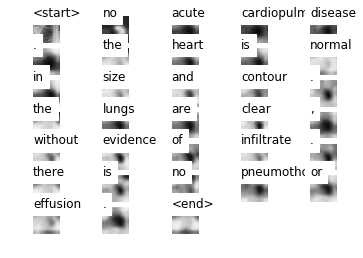

['<start>',
 'no',
 'acute',
 'cardiopulmonary',
 'disease',
 '.',
 'the',
 'heart',
 'is',
 'normal',
 'in',
 'size',
 'and',
 'contour',
 '.',
 'the',
 'lungs',
 'are',
 'clear',
 ',',
 'without',
 'evidence',
 'of',
 'infiltrate',
 '.',
 'there',
 'is',
 'no',
 'pneumothorax',
 'or',
 'effusion',
 '.',
 '<end>']

In [18]:
get_print('CXR2992_IM-1379-2002')

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


['the lungs are clear', 'heart size is normal', 'no pneumothorax', 'calcified granuloma within the right lung base']


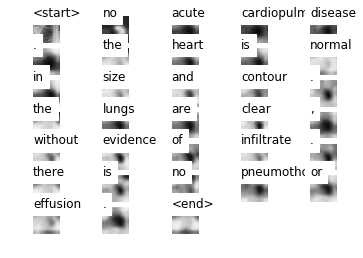

['<start>',
 'no',
 'acute',
 'cardiopulmonary',
 'disease',
 '.',
 'the',
 'heart',
 'is',
 'normal',
 'in',
 'size',
 'and',
 'contour',
 '.',
 'the',
 'lungs',
 'are',
 'clear',
 ',',
 'without',
 'evidence',
 'of',
 'infiltrate',
 '.',
 'there',
 'is',
 'no',
 'pneumothorax',
 'or',
 'effusion',
 '.',
 '<end>']

In [19]:
get_print('CXR2992_IM-1379-2002')

In [20]:
train_df.head(3)

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
0,CXR2357_IM-0921-1001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...
1,CXR2357_IM-0921-2001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...
0,CXR3620_IM-1791-1001-0001,The cardiac silhouette is near upper limits of...,1. Minimal left basilar atelectasis or scar. 2...,"[pulmonary atelectasis, base, left, mild, cica...","[atelectases, calcified granuloma, scar, atele...",./reports/ecgen-radiology/3620.xml,1. Minimal left basilar atelectasis or scar. 2...,"[minimal left basilar atelectasis or scar, no ...",[the cardiac silhouette is near upper limits o...,minimal left basilar atelectasis or scar . no ...


In [21]:
test_df.head(3)

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
1,CXR1484_IM-0313-2001,Calcified left lower lobe granuloma. No focal ...,No acute cardiopulmonary abnormality.,"[calcified granuloma, lung, lower lobe, left, ...","[degenerative change, granuloma]",./reports/ecgen-radiology/1484.xml,No acute cardiopulmonary abnormality. Calcifie...,"[no acute cardiopulmonary abnormality, calcifi...","[calcified left lower lobe granuloma, no focal...",no acute cardiopulmonary abnormality . calcifi...
0,CXR2767_IM-1212-1001,Lungs are clear. No pleural effusion or pneumo...,No evidence of active disease.,"[spine, degenerative, mild]",[degenerative change],./reports/ecgen-radiology/2767.xml,No evidence of active disease. Lungs are clear...,"[no evidence of active disease, lungs are clea...","[lungs are clear, no pleural effusion or pneum...",no evidence of active disease . lungs are clea...
1,CXR2767_IM-1212-2001,Lungs are clear. No pleural effusion or pneumo...,No evidence of active disease.,"[spine, degenerative, mild]",[degenerative change],./reports/ecgen-radiology/2767.xml,No evidence of active disease. Lungs are clear...,"[no evidence of active disease, lungs are clea...","[lungs are clear, no pleural effusion or pneum...",no evidence of active disease . lungs are clea...


In [22]:
test_predicts = []
test_images = test_df.images.values

In [23]:
train_predicts = []
train_images = train_df.images.values

In [24]:
from tqdm import tqdm_notebook

In [25]:
# for img_name in tqdm_notebook(train_images):
#     words = get_print(img_name, visualize=False, print_res=False)
#     train_predicts.append(words)

In [26]:
for img_name in tqdm_notebook(test_images):
    words = get_print(img_name, visualize=False, print_res=False)
    test_predicts.append(words)

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [27]:
test_predicts

[['<start>',
  'no',
  'acute',
  'cardiopulmonary',
  'abnormality',
  '.',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  '.',
  'cardiac',
  'and',
  'mediastinal',
  'silhouettes',
  'are',
  'normal',
  '.',
  'pulmonary',
  'vasculature',
  'is',
  'normal',
  '.',
  'no',
  'pneumothorax',
  'or',
  'pleural',
  'effusion',
  '.',
  'no',
  'acute',
  'bony',
  'abnormality',
  '.',
  '<end>'],
 ['<start>',
  'no',
  'acute',
  'cardiopulmonary',
  'abnormality',
  '.',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  '.',
  'cardiac',
  'and',
  'mediastinal',
  'silhouettes',
  'are',
  'normal',
  '.',
  'pulmonary',
  'vasculature',
  'is',
  'normal',
  '.',
  'no',
  'pneumothorax',
  'or',
  'pleural',
  'effusion',
  '.',
  'no',
  'acute',
  'bony',
  'abnormality',
  '.',
  '<end>'],
 ['<start>',
  'no',
  'acute',
  'cardiopulmonary',
  'abnormality',
  '.',
  'the',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  '.',
  'specifically',
  ',',
  'no',
  'evidenc

In [28]:
max_len = 100

In [29]:
test_image_captions = [[sents.split()][:max_len] for sents in test_df['preprocessed_full_report']]

In [32]:
# max_len=100

# # test_image_captions = [[[x for l in sents for x in l.split()][:max_len]] for sents in test_df['processed_findings']]
    
# test_image_captions = []
# for sents in test_df['processed_findings']:
#     cap = sents[0].split()
#     for sent in sents[1:]:
#         cap.append(',')
#         cap.extend(sent.split())
#     test_image_captions.append([cap[:max_len]])

In [33]:
# max_len=100
  
# test_image_captions = []
# for sents in train_df['processed_findings']:
#     cap = sents[0].split()
#     for sent in sents[1:]:
#         cap.append(',')
#         cap.extend(sent.split())
#     test_image_captions.append([cap[:max_len]])

In [30]:
np.argmax(list(map(len, test_predicts)))

191

In [32]:
test_predicts = [words[1:-1] for words in test_predicts]

In [36]:
# test_starts = [' '.join(i).split('.')[0] for i in test_predicts]

In [69]:
gpt_predicts = []

for i, test_start in tqdm_notebook(enumerate(test_starts)):
    input_ids = torch.tensor(tokenizer.encode(test_start, add_special_tokens=True)).unsqueeze(0)
    beam_outputs = gpt_model.generate(
                                input_ids, 
                                max_length=100, 
                                num_beams=7, 
                                no_repeat_ngram_size=2, 
                                num_return_sequences=1, 
                                early_stopping=True)
    tokenizer.decode(beam_output, skip_special_tokens=True)
    a = ' . '.join(tokenizer.decode(beam_output, skip_special_tokens=True).lower().replace('..', '.').replace(',','').split('.'))
    gpt_predicts.append(a.split())

In [48]:
input_ids = torch.tensor(tokenizer.encode(test_starts[0], add_special_tokens=True)).unsqueeze(0)

In [63]:
a = ' . '.join(tokenizer.decode(beam_output, skip_special_tokens=True).lower().replace('..', '.').replace(',','').split('.'))

In [64]:
a.split()

['no',
 'acute',
 'cardiopulmonary',
 'abnormality',
 '.',
 'the',
 'lungs',
 'are',
 'clear',
 'bilaterally',
 '.',
 'specifically',
 'no',
 'evidence',
 'of',
 'focal',
 'consolidation',
 'pneumothorax',
 'or',
 'pleural',
 'effusion',
 '.',
 'cardio',
 'mediastinal',
 'silhouette',
 'is',
 'unremarkable',
 '.',
 'visualized',
 'osseous',
 'structures',
 'of',
 'the',
 'thorax',
 'reveal',
 'no',
 'acute',
 'abnormalities',
 '.']

In [35]:
evalscores(test_predicts, test_image_captions)

Bleu_1: 0.319
Bleu_2: 0.195
Bleu_3: 0.129
Bleu_4: 0.088
ROUGE_L: 0.290
CIDEr: 0.285


In [70]:
evalscores(gpt_predicts, test_image_captions)

Bleu_1: 0.344
Bleu_2: 0.216
Bleu_3: 0.142
Bleu_4: 0.096
ROUGE_L: 0.279
CIDEr: 0.236


In [28]:
evalscores(test_predicts, test_image_captions)

Bleu_1: 0.319
Bleu_2: 0.190
Bleu_3: 0.125
Bleu_4: 0.084
ROUGE_L: 0.269
CIDEr: 0.208


In [33]:
test_predicts

[['no',
  'acute',
  'cardiopulmonary',
  'abnormality',
  '.',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  '.',
  'cardiac',
  'and',
  'mediastinal',
  'silhouettes',
  'are',
  'normal',
  '.',
  'pulmonary',
  'vasculature',
  'is',
  'normal',
  '.',
  'no',
  'pneumothorax',
  'or',
  'pleural',
  'effusion',
  '.',
  'no',
  'acute',
  'bony',
  'abnormality',
  '.'],
 ['no',
  'acute',
  'cardiopulmonary',
  'abnormality',
  '.',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  '.',
  'cardiac',
  'and',
  'mediastinal',
  'silhouettes',
  'are',
  'normal',
  '.',
  'pulmonary',
  'vasculature',
  'is',
  'normal',
  '.',
  'no',
  'pneumothorax',
  'or',
  'pleural',
  'effusion',
  '.',
  'no',
  'acute',
  'bony',
  'abnormality',
  '.'],
 ['no',
  'acute',
  'cardiopulmonary',
  'abnormality',
  '.',
  'the',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  '.',
  'specifically',
  ',',
  'no',
  'evidence',
  'of',
  'focal',
  'consolidation',
  ',',
  'pneumotho

In [35]:
evalscores(test_predicts, test_image_captions) # v10

Bleu_1: 0.325
Bleu_2: 0.207
Bleu_3: 0.142
Bleu_4: 0.101
ROUGE_L: 0.295
CIDEr: 0.333


In [39]:
' '.join(test_predicts[0])

'no acute cardiopulmonary abnormality . lungs are clear bilaterally . cardiac and mediastinal silhouettes are normal . pulmonary vasculature is normal . no pneumothorax or pleural effusion . no acute bony abnormality .'

In [40]:
pred_texts = [' '.join(i) for i in test_predicts]

In [9]:
evalscores(test_predicts, test_image_captions)

NameError: name 'test_predicts' is not defined

In [54]:
evalscores(test_predicts, test_image_captions)

Bleu_1: 0.343
Bleu_2: 0.203
Bleu_3: 0.131
Bleu_4: 0.087
ROUGE_L: 0.266
CIDEr: 0.202


In [65]:
evalscores(train_predicts, test_image_captions)

Bleu_1: 0.345
Bleu_2: 0.222
Bleu_3: 0.164
Bleu_4: 0.129
ROUGE_L: 0.299
CIDEr: 0.587


## Предсказание вместе с GPT-2

In [6]:
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup, get_constant_schedule, get_cosine_schedule_with_warmup,
                                  BertConfig, BertForMaskedLM, BertTokenizer,
                                  GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                                  OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                                  RobertaConfig, RobertaForMaskedLM, RobertaTokenizer,
                                  DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

I0511 08:51:55.535193 140409289340736 file_utils.py:41] PyTorch version 1.2.0 available.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dchesakov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dchesakov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [45]:
from transformers import GPT2Tokenizer, GPT2Model

import os
import numpy as np

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import torch

In [46]:
tokenizer = GPT2Tokenizer.from_pretrained('/home/dchesakov/transformers/output3')

I0429 14:50:06.806213 139891162220352 tokenization_utils.py:895] Model name '/home/dchesakov/transformers/output3' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming '/home/dchesakov/transformers/output3' is a path, a model identifier, or url to a directory containing tokenizer files.
I0429 14:50:06.808165 139891162220352 tokenization_utils.py:924] Didn't find file /home/dchesakov/transformers/output3/added_tokens.json. We won't load it.
I0429 14:50:06.809265 139891162220352 tokenization_utils.py:977] loading file /home/dchesakov/transformers/output3/vocab.json
I0429 14:50:06.810110 139891162220352 tokenization_utils.py:977] loading file /home/dchesakov/transformers/output3/merges.txt
I0429 14:50:06.810875 139891162220352 tokenization_utils.py:977] loading file None
I0429 14:50:06.811641 139891162220352 tokenization_utils.py:977] loading file /home/dchesakov/transformers/output3/special_tokens_map.json
I0429 14:50:06.812381 139891162220

In [47]:
gpt_model = GPT2LMHeadModel.from_pretrained('/home/dchesakov/transformers/output3', pad_token_id=tokenizer.eos_token_id)

I0429 14:50:07.258485 139891162220352 configuration_utils.py:284] loading configuration file /home/dchesakov/transformers/output3/config.json
I0429 14:50:07.259791 139891162220352 configuration_utils.py:322] Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "vocab_size": 50257
}

I0429 14:50:07.260983 139891162220352 modeling_utils.py:610] loading weights file /home/dchesakov/transformers/output3/pytorch_model.bin


In [11]:
tokenizer.encode("Hello, my dog is cute", add_special_tokens=False)

[15496, 11, 616, 3290, 318, 13779]

In [12]:
input_ids = torch.tensor(tokenizer.encode('Hi hello', add_special_tokens=True)).unsqueeze(0)

In [13]:
gpt_model(input_ids)[1][0].shape

torch.Size([2, 1, 12, 2, 64])

In [14]:
gpt_vocab = tokenizer.get_vocab()

In [51]:
def caption_image_beam_search_gpt(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)
    gpt_koeff = 0.

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        # print(step)
        
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)
        
        gpt_scores = idxs2gpt_predictions(seqs)
        gpt_scores = F.log_softmax(gpt_scores, dim=1)
        
        if step > 2:
            scores = top_k_scores.expand_as(scores) + (1-gpt_koeff)*scores + gpt_koeff*gpt_scores.cuda() # (s, vocab_size)
        else:
            scores = top_k_scores.expand_as(scores) + scores
        

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)
            

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
            # return (complete_seqs, complete_seqs_alpha, complete_seqs_scores)
            
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1
    try:
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
        alphas = complete_seqs_alpha[i]

        return seq, alphas
    except:
        return complete_seqs_scores, complete_seqs

In [52]:
def visualize_att_gpt(image_path, seq, alphas, rev_word_map, smooth=True, visualize=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    
    print(words)
    words = tokenizer.decode(tokenizer.encode(words[1:-1])).replace('.', ' . ').split()
    
    
    if visualize:
        for t in range(len(words)):
            if t > 50:
                break
            plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

            plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
            plt.imshow(image)
            current_alpha = alphas[t, :]
            if smooth:
                alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
            else:
                alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
            if t == 0:
                plt.imshow(alpha, alpha=0)
            else:
                plt.imshow(alpha, alpha=0.8)
            plt.set_cmap(cm.Greys_r)
            plt.axis('off')
        plt.show()
    
    return words

In [53]:
parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')

parser.add_argument('--img', '-i', default='/home/dchesakov/NLMCXR_data/myface.jpg', help='path to image')
parser.add_argument('--model', '-m', default='BEST_checkpoint_NLMCXR_vgpt_1_cap_per_img_0_min_word_freq.pth.tar', help='path to model')
parser.add_argument('--word_map', '-wm', default='/home/dchesakov/NLMCXR_data/WORDMAP_NLMCXR_vgpt_1_cap_per_img_0_min_word_freq.json',  help='path to word map JSON')
parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')

_StoreFalseAction(option_strings=['--dont_smooth'], dest='smooth', nargs=0, const=False, default=True, type=None, choices=None, help='do not smooth alpha overlay', metavar=None)

In [54]:
'CXR3275_IM-1556-1003002'

'CXR3275_IM-1556-1003002'

In [44]:
# Load model
args = parser.parse_args('')

In [45]:
checkpoint = torch.load(args.model)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(args.word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
# seq, alphas = caption_image_beam_search(encoder, decoder, args.img, word_map, args.beam_size)
# alphas = torch.FloatTensor(alphas)

# # Visualize caption and attention of best sequence
# visualize_att(args.img, seq, alphas, rev_word_map, args.smooth)

In [21]:
img_name = 'CXR2992_IM-1379-2002'
img = f'/home/dchesakov/NLMCXR_data/images/{img_name}.png'

In [22]:
vocab_gpt = tokenizer.get_vocab()

In [23]:
rev_vocab_gpt = {i:v for v, i in vocab_gpt.items()}

In [24]:
def idxs2gpt_predictions(batch_idx):
    predictions = torch.ones((batch_idx.shape[0], len(word_map)))
    
    for j, idx in enumerate(batch_idx):
        tokens = [rev_word_map[int(i)] for i in idx]
        torch_tokens = torch.tensor(tokenizer.encode(tokens)).unsqueeze(0)
        predictions[j, :] = gpt_model(torch_tokens)[0][0][gpt_indexes]
    
    return predictions

In [25]:
for i, a in enumerate([21, 21, 21]):
    break

In [26]:
i, a

(0, 21)

In [29]:
# len(gpt_indexes)

In [30]:
len(word_map)

2395

In [31]:
gpt_indexes = []
err_tokens = []

for token in word_map.keys():
    try:
        gpt_indexes.append(gpt_vocab[token])
    except:
        gpt_indexes.append(gpt_vocab['<|endoftext|>'])
        err_tokens.append(token)

In [32]:
err_tokens

['<unk>', '<end>', '<start>', '<pad>']

In [35]:
a = caption_image_beam_search_gpt(encoder, decoder, img, word_map, 5)

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [201]:
idxs2gpt_predictions(seqs).shape

torch.Size([5, 2395])

In [127]:
k_prev_words, seqs = caption_image_beam_search_gpt(encoder, decoder, img, word_map, 5)

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [128]:
k_prev_words

tensor([[  2],
        [152],
        [ 59],
        [196],
        [323]], device='cuda:0')

In [129]:
seqs

tensor([[2394,    1,    2],
        [2394,    1,  152],
        [2394,   76,   59],
        [2394,    1,  196],
        [2394,  788,  323]], device='cuda:0')

In [176]:
rev_word_map[int(i)]

'<pad>'

In [177]:
tokens = [rev_word_map[int(i)] for i in seqs[0]]

In [179]:
tokens.append('<pad>')

In [180]:
# tokens = [rev_word_map[int(i)] for i in seqs[0]]
torch_tokens = torch.tensor(tokenizer.encode(tokens)).unsqueeze(0)

In [186]:
tokenizer.decode([50256])

'<|endoftext|>'

In [181]:
torch_tokens

tensor([[50256,  3919, 14352, 50256]])

In [193]:
gpt_model(torch_tokens)[0][0][-1][gpt_indexes].shape

torch.Size([2395])

In [161]:
rev_vocab_gpt[14352]

'Ġacute'

In [109]:
top_k_scores.expand_as(scores).shape

torch.Size([5, 2395])

In [85]:
top_k_scores.expand_as(scores) + scores

tensor([[2394,    1,    2],
        [2394,    1,  152],
        [2394,   76,   59],
        [2394,    1,  196],
        [2394,  788,  323]], device='cuda:0')

In [86]:
top_k_scores

tensor([[-0.5094],
        [-3.1064],
        [-3.2940],
        [-3.4707],
        [-4.2222]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [93]:
scores.shape

torch.Size([5, 2395])

In [99]:
scores.view(-1).topk(5, 0, True, True)

torch.return_types.topk(
values=tensor([-0.8322, -2.9614, -3.1134, -3.5566, -3.6613], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([   3,  154, 2452, 7339,  215], device='cuda:0'))

In [100]:
scores.view(-1).topk(5)

torch.return_types.topk(
values=tensor([-0.8322, -2.9614, -3.1134, -3.5566, -3.6613], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([   3,  154, 2452, 7339,  215], device='cuda:0'))

In [89]:
len(complete_seqs_alpha[0][-1])

14

In [90]:
complete_seqs_scores[0]

tensor(-8.5671, device='cuda:0', grad_fn=<SelectBackward>)

In [91]:
i = complete_seqs_scores.index(max(complete_seqs_scores))

In [65]:
max(complete_seqs_scores)

tensor(-8.5671, device='cuda:0', grad_fn=<SelectBackward>)

In [69]:
seq = complete_seqs[i]

In [72]:
complete_seqs[0]

[2394,
 1,
 2,
 3,
 4,
 5,
 6,
 154,
 8,
 52,
 106,
 54,
 21,
 58,
 59,
 8,
 52,
 103,
 11,
 236,
 237,
 54,
 222,
 223,
 8,
 52,
 23,
 19,
 24,
 8,
 2393]

In [79]:
tokenizer.decode(tokenizer.encode([rev_word_map[i] for i in seq][1:-1]))

'no acute cardiopulmonary disease. the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.'

In [78]:
tokenizer.encode([rev_word_map[i] for i in seq])

[50256,
 3919,
 14352,
 2657,
 14922,
 377,
 36639,
 4369,
 764,
 262,
 2612,
 318,
 3487,
 287,
 2546,
 764,
 262,
 16957,
 459,
 259,
 388,
 318,
 49733,
 45543,
 764,
 262,
 21726,
 389,
 1598,
 764,
 50256]

In [27]:
word_map

{'no': 1,
 'Ġacute': 2,
 'Ġcard': 3,
 'iop': 4,
 'ul': 5,
 'monary': 6,
 'Ġfindings': 7,
 'Ġ.': 8,
 'i': 9,
 'omed': 10,
 'ast': 11,
 'inal': 12,
 'Ġsilhouette': 13,
 'Ġand': 14,
 'Ġpulmonary': 15,
 'Ġvas': 16,
 'cul': 17,
 'ature': 18,
 'Ġare': 19,
 'Ġwithin': 20,
 'Ġnormal': 21,
 'Ġlimits': 22,
 'Ġlungs': 23,
 'Ġclear': 24,
 'Ġno': 25,
 'Ġpneum': 26,
 'oth': 27,
 'or': 28,
 'ax': 29,
 'Ġor': 30,
 'Ġple': 31,
 'ural': 32,
 'Ġeff': 33,
 'usion': 34,
 'Ġos': 35,
 'se': 36,
 'ous': 37,
 'min': 38,
 'imal': 39,
 'Ġleft': 40,
 'Ġbas': 41,
 'ilar': 42,
 'Ġat': 43,
 'elect': 44,
 'asis': 45,
 'Ġscar': 46,
 'Ġ,': 47,
 'Ġdisplaced': 48,
 'Ġrib': 49,
 'Ġfractures': 50,
 'Ġdemonstrated': 51,
 'Ġthe': 52,
 'Ġcardiac': 53,
 'Ġis': 54,
 'Ġnear': 55,
 'Ġupper': 56,
 'Ġof': 57,
 'Ġin': 58,
 'Ġsize': 59,
 'Ġcaliber': 60,
 'Ġthere': 61,
 'Ġminimal': 62,
 'Ġx': 63,
 'xxx': 64,
 'Ġlung': 65,
 'Ġbase': 66,
 'Ġotherwise': 67,
 'Ġgrossly': 68,
 'Ġa': 69,
 'Ġsmall': 70,
 'Ġcalc': 71,
 'ified': 72,
 'Ġgran': 

In [55]:
def get_print_gpt(img_name, visualize=True, print_res=True):
    parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')
    parser.add_argument('--img', '-i', default=f'/home/dchesakov/NLMCXR_data/images/{img_name}.png', help='path to image')
    parser.add_argument('--model', '-m', default='BEST_checkpoint_NLMCXR_vgpt_1_cap_per_img_0_min_word_freq.pth.tar', help='path to model')
    parser.add_argument('--word_map', '-wm', default='/home/dchesakov/NLMCXR_data/WORDMAP_NLMCXR_vgpt_1_cap_per_img_0_min_word_freq.json',  help='path to word map JSON')
    parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
    parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')
    
    args = args = parser.parse_args('')
    
    checkpoint = torch.load(args.model)
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(args.word_map, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search_gpt(encoder, decoder, args.img, word_map, args.beam_size)
    alphas = torch.FloatTensor(alphas)
    
    if print_res:
        print(asd[ asd['images'] == f'{img_name}']['processed_findings'].iloc[0])

    # Visualize caption and attention of best sequence
    words = visualize_att_gpt(args.img, seq, alphas, rev_word_map, args.smooth, visualize=visualize)
    
    return words

In [47]:
import pandas as pd

In [48]:
asd = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_df.pkl')

In [49]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

all_reports_df = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_tags_df.pkl')
    # all_reports_df = all_reports_df[ all_reports_df['processed_findings'].notnull() ]
# train_df, val_df, test_df = train_validate_test_split(all_reports_df, .9, .05, seed=42)
train_df = all_reports_df[:-600]
val_df = all_reports_df[-600:-300]
test_df = all_reports_df[-300:]

In [32]:
# all_reports_df = pd.read_pickle('/home/dchesakov/NLMCXR_data/all_reports_df.pkl')
# all_reports_df['processed_captions'] = [eval(cap) for cap in all_reports_df['processed_captions']]
# all_reports_df = all_reports_df[ all_reports_df['processed_findings'].notnull() ]

# train_df = all_reports_df[:-600]
# val_df = all_reports_df[-600:-300]
# test_df = all_reports_df[-300:]

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


['the lungs are clear', 'heart size is normal', 'no pneumothorax', 'calcified granuloma within the right lung base']
['<start>', 'no', 'Ġacute', 'Ġcard', 'iop', 'ul', 'monary', 'Ġdisease', 'Ġ.', 'Ġthe', 'Ġheart', 'Ġis', 'Ġnormal', 'Ġin', 'Ġsize', 'Ġ.', 'Ġthe', 'Ġmedi', 'ast', 'in', 'um', 'Ġis', 'Ġunrem', 'arkable', 'Ġ.', 'Ġthe', 'Ġlungs', 'Ġare', 'Ġclear', 'Ġ.', '<end>']


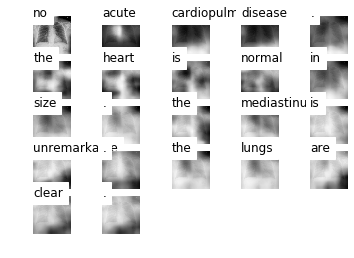

['no',
 'acute',
 'cardiopulmonary',
 'disease',
 '.',
 'the',
 'heart',
 'is',
 'normal',
 'in',
 'size',
 '.',
 'the',
 'mediastinum',
 'is',
 'unremarkable',
 '.',
 'the',
 'lungs',
 'are',
 'clear',
 '.']

In [56]:
get_print_gpt('CXR2992_IM-1379-2002')

In [57]:
get_print('CXR2992_IM-1379-2002')

NameError: name 'get_print' is not defined

In [20]:
train_df.head(3)

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
0,CXR2357_IM-0921-1001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...
1,CXR2357_IM-0921-2001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...
0,CXR3620_IM-1791-1001-0001,The cardiac silhouette is near upper limits of...,1. Minimal left basilar atelectasis or scar. 2...,"[pulmonary atelectasis, base, left, mild, cica...","[atelectases, calcified granuloma, scar, atele...",./reports/ecgen-radiology/3620.xml,1. Minimal left basilar atelectasis or scar. 2...,"[minimal left basilar atelectasis or scar, no ...",[the cardiac silhouette is near upper limits o...,minimal left basilar atelectasis or scar . no ...


In [21]:
test_df.head(3)

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
1,CXR1484_IM-0313-2001,Calcified left lower lobe granuloma. No focal ...,No acute cardiopulmonary abnormality.,"[calcified granuloma, lung, lower lobe, left, ...","[degenerative change, granuloma]",./reports/ecgen-radiology/1484.xml,No acute cardiopulmonary abnormality. Calcifie...,"[no acute cardiopulmonary abnormality, calcifi...","[calcified left lower lobe granuloma, no focal...",no acute cardiopulmonary abnormality . calcifi...
0,CXR2767_IM-1212-1001,Lungs are clear. No pleural effusion or pneumo...,No evidence of active disease.,"[spine, degenerative, mild]",[degenerative change],./reports/ecgen-radiology/2767.xml,No evidence of active disease. Lungs are clear...,"[no evidence of active disease, lungs are clea...","[lungs are clear, no pleural effusion or pneum...",no evidence of active disease . lungs are clea...
1,CXR2767_IM-1212-2001,Lungs are clear. No pleural effusion or pneumo...,No evidence of active disease.,"[spine, degenerative, mild]",[degenerative change],./reports/ecgen-radiology/2767.xml,No evidence of active disease. Lungs are clear...,"[no evidence of active disease, lungs are clea...","[lungs are clear, no pleural effusion or pneum...",no evidence of active disease . lungs are clea...


In [58]:
test_predicts = []
test_images = test_df.images.values

In [102]:
train_predicts = []
train_images = train_df.images.values

In [59]:
from tqdm import tqdm_notebook

In [80]:
# for img_name in tqdm_notebook(train_images):
#     words = get_print(img_name, visualize=False, print_res=False)
#     train_predicts.append(words)

In [60]:
get_print_gpt(test_images[0], visualize=False, print_res=False)

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


['<start>', 'no', 'Ġacute', 'Ġcard', 'iop', 'ul', 'monary', 'Ġabnormalities', 'Ġ.', 'Ġthe', 'Ġheart', 'Ġis', 'Ġnormal', 'Ġin', 'Ġsize', 'Ġ.', 'Ġthe', 'Ġmedi', 'ast', 'in', 'um', 'Ġis', 'Ġunrem', 'arkable', 'Ġ.', 'Ġthe', 'Ġlungs', 'Ġare', 'Ġclear', 'Ġ.', '<end>']


['no',
 'acute',
 'cardiopulmonary',
 'abnormalities',
 '.',
 'the',
 'heart',
 'is',
 'normal',
 'in',
 'size',
 '.',
 'the',
 'mediastinum',
 'is',
 'unremarkable',
 '.',
 'the',
 'lungs',
 'are',
 'clear',
 '.']

In [61]:
max_len = 100

In [62]:
test_image_captions = [[sents.split()][:max_len] for sents in test_df['preprocessed_full_report']]

In [ ]:
err_idx = []
ok_idx = []

for i, img_name in tqdm_notebook(enumerate(test_images)):
    try:
        words = get_print_gpt(img_name, visualize=False, print_res=False)
        test_predicts.append(words)
        ok_idx.append(i)
    except:
        err_idx.append(i)

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


['<start>', 'no', 'Ġacute', 'Ġcard', 'iop', 'ul', 'monary', 'Ġabnormalities', 'Ġ.', 'Ġthe', 'Ġheart', 'Ġis', 'Ġnormal', 'Ġin', 'Ġsize', 'Ġ.', 'Ġthe', 'Ġmedi', 'ast', 'in', 'um', 'Ġis', 'Ġunrem', 'arkable', 'Ġ.', 'Ġthe', 'Ġlungs', 'Ġare', 'Ġclear', 'Ġ.', '<end>']
['<start>', 'no', 'Ġacute', 'Ġcard', 'iop', 'ul', 'monary', 'Ġabnormalities', 'Ġ.', 'Ġthe', 'Ġheart', 'Ġis', 'Ġnormal', 'Ġin', 'Ġsize', 'Ġ.', 'Ġthe', 'Ġmedi', 'ast', 'in', 'um', 'Ġis', 'Ġunrem', 'arkable', 'Ġ.', 'Ġthe', 'Ġlungs', 'Ġare', 'Ġclear', 'Ġ.', '<end>']
['<start>', 'no', 'Ġacute', 'Ġcard', 'iop', 'ul', 'monary', 'Ġabnormalities', 'Ġ.', 'Ġthe', 'Ġheart', 'Ġis', 'Ġnormal', 'Ġin', 'Ġsize', 'Ġ.', 'Ġthe', 'Ġmedi', 'ast', 'in', 'um', 'Ġis', 'Ġunrem', 'arkable', 'Ġ.', 'Ġthe', 'Ġlungs', 'Ġare', 'Ġclear', 'Ġ.', '<end>']
['<start>', 'no', 'Ġacute', 'Ġcard', 'iop', 'ul', 'monary', 'Ġabnorm', 'ality', 'Ġ.', 'Ġthe', 'Ġcard', 'i', 'omed', 'i', 'ast', 'inal', 'Ġsilhouette', 'Ġis', 'Ġwithin', 'Ġnormal', 'Ġlimits', 'Ġfor', 'Ġsize', 'Ġa

In [105]:
max_len = 100

test_image_captions = [[sents.split()][:max_len] for sents in test_df['preprocessed_full_report']]

In [84]:
for img_name in tqdm_notebook(test_images):
    try:
        image_path = f'/home/dchesakov/NLMCXR_data/images/{img_name}.png'
        a, b = caption_image_beam_search_gpt(encoder, decoder, image_path, word_map, beam_size=3) 
        break
    except:
        pass

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
model

In [113]:
# get_print_gpt(img_name, visualize=False, print_res=False)

In [120]:
test_predicts[126]

['no',
 'acute',
 'cardiopulmonary',
 'abnormality',
 '.',
 'the',
 'cardiomediastinal',
 'silhouette',
 'and',
 'pulmonary',
 'vasculature',
 'are',
 'within',
 'normal',
 'limits',
 '.',
 'there',
 'is',
 'no',
 'pneumothorax',
 'or',
 'pleural',
 'effusion',
 '.',
 'there',
 'are',
 'no',
 'focal',
 'areas',
 'of',
 'consolidation',
 '.']

In [119]:
test_image_captions[126]

[['no',
  'cardiopulmonary',
  'abnormality',
  '.',
  'heart',
  'size',
  'is',
  'within',
  'normal',
  'limits',
  '.',
  'cardiomediastinal',
  'silhouette',
  'is',
  'normal',
  '.',
  'lungs',
  'are',
  'clear',
  'bilaterally',
  'without',
  'effusion',
  'or',
  'pneumothorax',
  '.',
  'no',
  'bony',
  'or',
  'soft',
  'tissue',
  'abnormalities',
  '.']]

In [112]:
evalscores(test_predicts, test_image_captions)

Bleu_1: 0.234
Bleu_2: 0.148
Bleu_3: 0.101
Bleu_4: 0.071
ROUGE_L: 0.271
CIDEr: 0.275


In [122]:
[[word_map['<start>']]] * 10

[[2394],
 [2394],
 [2394],
 [2394],
 [2394],
 [2394],
 [2394],
 [2394],
 [2394],
 [2394]]